In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from fem_1d import *
#from qva import *
from pauliDecomp import *
from scipy.sparse import diags
import pprint
import qiskit
from qiskit import QuantumCircuit
from qva2 import *
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit_ibm_runtime import Sampler, Session, Options
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account.
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="")
#service = QiskitRuntimeService()
pp = pprint.PrettyPrinter(width=110, compact=True)

##############################################
##############################################
# Analytic Solutions
def u_cubic(x):
    return (-x**3+x**2+x+1)

def u_quadratic(x):
    xo = 1/2
    g  = 0
    b_analytic1 = 1/np.sqrt(4)  # choose this so that an 3bit RHS is already normalized
    b_coeff  = -(1/2)*b_analytic1 # gives k = 1/sqrt(8)
    a = g - b_coeff*(-xo)**2
    return (a + b_coeff*(x - xo)**2)

def u_heat(x,t):
    return (1./np.sqrt(4. * np.pi * t)) * np.exp(-pow(x-0.5,2)/(4.0 * t))


PauliDecomp:  [[2.00000000000000, 'II', [0, 0]], [-1.00000000000000, 'IX', [0, 1]], [-0.500000000000000, 'XX', [1, 1]], [-0.500000000000000, 'YY', [2, 2]]]
A:  [[ 2. -1. -0. -0.]
 [-1.  2. -1. -0.]
 [-0. -1.  2. -1.]
 [-0. -0. -1.  2.]]
A_PD:  Matrix([[2.00000000000000, -1.00000000000000, 0, 0], [-1.00000000000000, 2.00000000000000, -1.00000000000000, 0], [0, -1.00000000000000, 2.00000000000000, -1.00000000000000], [0, 0, -1.00000000000000, 2.00000000000000]])
PauliDecomp:  [[2.00000000000000, 'II', [0, 0]], [-1.00000000000000, 'IX', [0, 1]], [-0.500000000000000, 'XX', [1, 1]], [-0.500000000000000, 'YY', [2, 2]]]
PauliDecomp for Estimator ['II', 'IX', 'XX', 'YY']
c:  [2.00000000000000, -1.00000000000000, -0.500000000000000, -0.500000000000000]
g:  [[0, 0], [1, 0], [1, 1], [2, 2]]
ul:  0.0  || ur:  0.0
B: [0.02 0.02 0.02 0.02]
u_fem:  [0.   0.04 0.06 0.06 0.04 0.  ]
u_analytic:  [0.   0.04 0.06 0.06 0.04 0.  ]
nlayers:  2  || irun:  0
Number of parameters 4 and length 4
iteration:  1  |

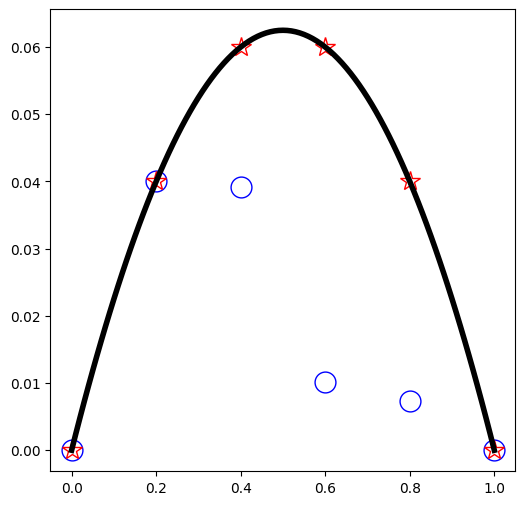

In [2]:
##################################################
##################################################
#                  Poisson Solve                 #
##################################################
##################################################
# Choose a Manufactured Solution
#case = "cubic"; u_analytic = u_cubic
case = "quadratic"; u_analytic = u_quadratic

##################################################
# Parameters
layer_range = 1
layer_start = 2 #2
run_range = 1
nqbits = 2
maxiter = 1000 #4000
reduced = 1
method = "COBYLA"
rhobeg = np.pi#/10.0

##################################################
# Define and Solve the FEM Problem
xl = 0; xr = 1; ni = 2**(nqbits); nx = ni + 2    # TRY SHIFTING THE DOMAIN OVER BY ONE, THIS WILL FORCE ALL B ENTRIES TO BE +
h,x = create_grid(nx,xl,xr)

# Get FEM Matrix Pauli Decomposition
A = -diags([1, -2, 1], [-1, 0, 1], shape=(ni, ni)).toarray()
result,gates = pauli_decomp(nqbits,A,Pauli,Pauli_Names,nPauli)
print("PauliDecomp: ",result)
c = []; g = []; 
for i in range(len(result)):
    gt = [None] * nqbits
    for j in range(nqbits):
        gt[nqbits-j - 1] = result[i][2][j]
    #print("qt: ",gt)
    #print("g: ",result[i][2])
    c.append(result[i][0])
    g.append(gt)
A_PD = build_matrix_from_decomp(result)
    
print("A: ",A)
print("A_PD: ",A_PD)
print("PauliDecomp: ",result)
print("PauliDecomp for Estimator", gates)
print("c: ",c)
print("g: ",g)

# boundary conditions and scaling values
ul = u_analytic(xl); ur = u_analytic(xr); uscale = u_analytic(x[1]);
print("ul: ",ul," || ur: ",ur)

# calculate RHS
b = np.zeros(ni)
if reduced == 1:
    if case == "quadratic":
        b[0:ni] = h*.1
    elif case == "cubic":   
        print("Cubic")
        b = (h*h*(6*x[1:nx-1]-2) *h*.1)
    b[0] = b[0] - A[0,1] * ul 
    b[ni-1] = b[ni-1] - A[0,1] * ur 
print(f'B: {b}')
#else:
    #b = u_cubic_rhs(x)
    #b[0] = ul
    #b[n-1] = ur
#print("b: ",b)
    
# Solve the discrete system
u_fem = np.zeros(nx)
u_fem[1:nx-1] = np.linalg.solve(A, b)
u_fem[0] = ua = u_analytic(xl)
u_fem[nx-1] = ua = u_analytic(xr)
print("u_fem: ",u_fem)
ht,xt = create_grid(ni+2,xl,xr)
ua = u_analytic(xt)
print("u_analytic: ",ua)

##################################################
##################################################
file = open(case + "_LayerRange_" + str(layer_range) + "_layerStart_" + str(layer_start) + "_runRange_" + str(run_range) + "_" + str(nqbits) + "qbit"".txt",'w')
for j in range(0,layer_range):
    nlayers = layer_start + j
    for i in range(0,run_range):
        print("nlayers: ",nlayers," || irun: ",i)
        
        #random.seed()
        nparameters = nqbits + 2*(nqbits-1)*(nlayers-1)
        parameters = [float(random.randint(-3100,3100))/1000 for i in range(0, nparameters)]
        
        nit = 0
        cost_values = []

        ## OLD CODE ##
        #u, parameters, cost_values = run_qva(nqbits,nlayers,maxiter,c,g,b,parameters,method,rhobeg,ul,ur,uscale,reduced)

        ## NEW CODE  WITH ESTIMATOR ##
        u, parameters, cost_values = new_run_qva(nqbits, nlayers,maxiter,c,gates,b,parameters,method,rhobeg,ul,ur,uscale,reduced)

        # Write data to file
        file.write("nlayers %d  irun %d ncost %d nu %d\n" % (nlayers,i,len(cost_values),len(u)))
        for ii in range(0,len(cost_values)):
            file.write("%f "%cost_values[ii])
        file.write("\n")
        for ii in range(0,len(u)):
            file.write("%f "%u[ii])
        file.write("\n")
        #file.writelines("%s\n" % cost_values)
        #file.writelines("%s\n" % u)
file.close()
##################################################
##################################################
# quick plot of last run
print(f'QVA-- X: {x}   U: {u}')
print(f'U_FEM-- X: {x}   U_FEM: {u_fem}')
print(f'U_ANALYTIC-- X: {x}   U_ANALYTIC: {u_analytic}')
hp,xp = create_grid(101,xl,xr)
fig = plt.figure(figsize=(6, 6),facecolor=(1, 1, 1))
plt.plot(x,u,color="blue",linestyle='none',marker='o',markersize=15,markerfacecolor='none',linewidth=1.0,label='QVA')
plt.plot(x,u_fem,color="red",linestyle='none',marker='*',markersize=15,markerfacecolor='none',linewidth=1.0,label='FEM')
plt.plot(xp,u_analytic(xp),color="black",linestyle='-',linewidth=4.0,label='Analytic Solution')
plt.show()

INSIDE PAULI DECOMP
RANGES ((0, 4), (0, 4))
P: Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])


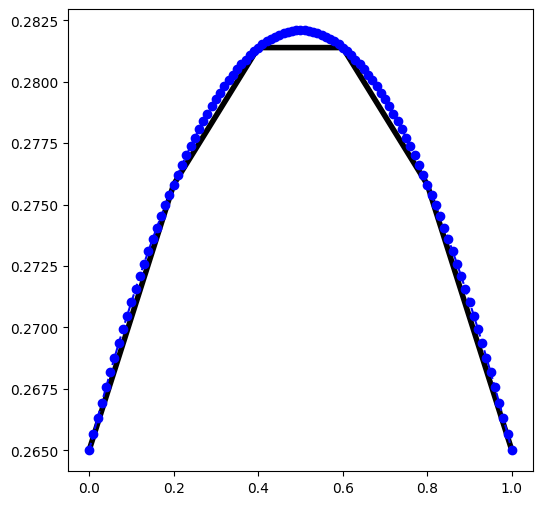

Traceback (most recent call last):
  File "/Users/claireellison/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_cobyla_py.py", line 273, in calcfc
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = fun(np.copy(x), *args)
  File "/Users/claireellison/Documents/quantum_algorithms/qva_fem/qva.py", line 436, in cost_function
    norm += my_coefficient_set[i] * my_coefficient_set[j].conjugate() * complex(psi_norm_hadamard(nqbits,my_gate_set[i],my_gate_set[j],"Re",parameters,nlayers), \
AttributeError: 'list' object has no attribute 'conjugate'


: 

: 

In [17]:
# Heat Equation Solve
nqbits = 2 #3 #2
nlayers = 3#. 6 #3
maxiter = 200 #2000 #200
reduced = 1
method = "COBYLA"
rhobeg = np.pi/10.0

# Define and Solve the FEM Problem
xl = 0; xr = 1; nx = 2**(nqbits) + 2;
tl = 1; tr = 3; nt = 11
u_analytic, x, t, M, A, dt, h = heat_solve(xl,xr,nx,tl,tr,nt,reduced,u_heat)  # returns reduced matrices, but x is full

# Initial QVA Parameters
random.seed()
nparameters = nqbits + 2*(nqbits-1)*(nlayers-1)
parameters = [float(random.randint(-3100,3100))/1000 for i in range(0, nparameters)]

# Get FEM Matrix Pauli Decomposition
result = pauli_decomp(nqbits,A,Pauli,Pauli_Names,nPauli)
c = []; g = []; 
for i in range(len(result)):
    gt = [None] * nqbits
    for j in range(nqbits):
        gt[nqbits-j - 1] = result[i][2][j]
    c.append(result[i][0])
    g.append(gt)


# 2 qbit Heat Equation
#parameters = [-0.271168, -1.418207,  3.262556, -3.699268, -1.848239,  2.757174]
#g = [[0, 0],[0, 1],[1, 1],[2, 2]]
#c = [2.13333333333333, -0.966666666666667, -0.483333333333333,-0.483333333333333]

u = u_heat(x,tl)
u_store = []; cost_values_store = [];
u_store.append(u.tolist())

h,x = create_grid(nx,xl,xr)
hh,xp = create_grid(101,xl,xr)
fig = plt.figure(figsize=(6, 6),facecolor=(1, 1, 1))
plt.plot(x,u,color="black",linewidth=4.0,label='Discrete Solution')
plt.plot(xp,u_heat(xp,tl),color="blue",linestyle='--',marker='o',label='Analytic Solution')
plt.show()

for n1 in range(nt):
    time = tl + n1 * dt + dt # t^(n+1)
    
    # boundary conditions and scaling values
    ul = u_heat(xl,time)
    ur = u_heat(xr,time)
    uscale = u_heat(x[1],time)

    # calculate RHS
    if reduced == 1:
        b = np.matmul(M,u[1:nx-1])
        b[0] = b[0] + M[0,1] * u_heat(xl,tl) - A[0,1] * ul
        b[nx-3] = b[nx-3] + M[0,1] * u_heat(xr,tl) - A[0,1] * ur
    else:
        u_old = u_heat(x,tl)
        b = np.matmul(M,u)
        b[0] = ul
        b[n-1] = ur

    #############################################################################################################
    #nit = 0
    #cost_values = []
    u, parameters, cost_values = run_qva(nqbits,nlayers,maxiter,c,g,b,parameters,method,rhobeg,ul,ur,uscale,reduced)
    #############################################################################################################

    cost_values_store.append(cost_values)
    u_store.append(u.tolist())
    
    fig = plt.figure(figsize=(6, 6),facecolor=(1, 1, 1))
    plt.plot(x,u,color="black",linewidth=4.0,label='Discrete Solution')
    plt.plot(xp,u_heat(xp,time),color="blue",linestyle='--',marker='o',label='Analytic Solution')
    plt.show()
    

In [1]:
# Plot the results
fig = plt.figure(figsize=(12, 18),facecolor=(1, 1, 1))
nrows = 4
ncols = 3
gs = fig.add_gridspec(nrows,ncols)
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs[i, j])
        time = tl + count * dt
        ax.plot(x,u_store[count],color="black",linestyle='--',marker='o',markersize=15,markerfacecolor='none',linewidth=1.0,label='Discrete Solution')
        ax.plot(xp,u_heat(xp,tl+dt*count),color="black",label='Analytic Solution')
        if count==0 or count==3 or count==6 or count==9:
            ax.set_ylabel("f(x,t)", fontsize=18)
        #ax.set_xlabel("x", fontsize=12)
        ax.grid()
        ax.set_ylim([min(min(u_store)),max(max(u_store))+0.01])
        ax.text(0.5, max(max(u_store))+0.015,'time: %.1fs'%(time),color="black",fontsize=18,ha='center')
        count = count + 1
        if count == nt:
            break
#plt.savefig("/Users/corey/Dropbox/QUANTUM_COMPUTING/NEW_CODE/package/images/heat_solution_3q.png",dpi=300,format='png',bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

In [3]:
tt = np.zeros(nt)
it = np.zeros(nt)
for i in range(0,nt):
    tt[i] = tl + i*dt
    it[i] = len(cost_values_store[i])
    
fig = plt.figure(figsize=(8, 6),facecolor=(1, 1, 1))
plt.plot(tt,it,"o-",ms=14, color='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("iteration count", fontsize=20)
plt.xlabel("time(s)", fontsize=18)
plt.grid()
#fname = "/Users/corey/Desktop/Quantum_Notebooks/paper_results/final_plots/fe_vqls_3qbit_iteration_count.png"
plt.savefig(fname,dpi=300,format='png',bbox_inches='tight')
plt.show()

NameError: name 'nt' is not defined

In [10]:
# calculate RHS
case = "cubic"; u_analytic = u_cubic
#case = "quadratic"; u_analytic = u_quadratic
reduced = 1
nqbits = 3
xl = 0; xr = 1; ni = 2**(nqbits); nx = ni + 2
h,x = create_grid(nx,xl,xr)
A = -diags([1, -2, 1], [-1, 0, 1], shape=(ni, ni)).toarray()
ul = u_analytic(xl); ur = u_analytic(xr); uscale = u_analytic(x[1]);

b = np.zeros(ni)
if reduced == 1:
    if case == "quadratic":
        b[0:ni] = 1
    elif case == "cubic":   
        print("Cubic")
        b = h*h*(6*x[1:nx-1]-2) 
    b[0] = b[0] - A[0,1] * ul 
    b[ni-1] = b[ni-1] - A[0,1] * ur 
    
def obtain_circuit_from_vec(desired_vec,circ, qubits):
    #circ.isometry(desired_vec,qubits,[])
    controlled_gate = StatePreparation(desired_vec)
    
    circ.append(controlled_gate,qubits)
    #circ.initialize(desired_vec,qubits)
    circ = circ.decompose().decompose().decompose().decompose()
    circ = transpile(circ,basis_gates=['rx','ry','rz', 'h', 'cx'])#basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ

def swap_gates(a,control,new_circ):
    #coded for basis_gates=['rx','ry','rz', 'h', 'cx']
    if a[0].name == 'rx':
        new_name ='crx'
        new_bits = [control,a[1][0].index]
        new_circ.crx(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'ry':
        new_name ='cry'
        new_bits = [control,a[1][0].index]
        new_circ.cry(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'rz':
        new_name= 'crz'
        new_bits = [control,a[1][0].index]
        new_circ.crz(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'h':
        new_name = 'ch'
        new_bits = [control,a[1][0].index]
        new_circ.ch(a[0].params[0],new_bits[0],new_bits[1])
    elif a[0].name == 'cx':
        new_name = 'ccx'
        new_bits = [control,a[1][0].index,a[1][1].index]
        new_circ.ccx(new_bits[0],new_bits[1],new_bits[2])
    return new_name, new_bits

def Ph(quantum_circuit, theta, qubit,control_bit):
    quantum_circuit.cu1(theta,control_bit, qubit)
    quantum_circuit.cx(control_bit,qubit)
    quantum_circuit.cu1(theta,control_bit, qubit)
    quantum_circuit.cx(control_bit,qubit)
    return 0

def control_version(circ,new_circ,control_bit):
    #global phase shift
    #Ph(new_circ,circ.global_phase,1,control_bit)
    
    for a in circ:
        new_name,new_bits = swap_gates(a,control_bit,new_circ)
        #my_gate = Gate(name=new_name, num_qubits=a[0].num_qubits+1,  params=a[0].params)
        #new_circ.append(my_gate, new_bits)
    #new_circ = new_circ.inverse()
    return new_circ

def control_b(circ,auxilary,qubits,input_circ):
    #nq = circ.num_qubits
    circ=circ.compose(input_circ)
    return circ

print(b)

# Normalize this vector
b = b/np.linalg.norm(b)
b = np.array(b,dtype=complex)
    
aux = 0
qubitsRHS = [1]
for i in range(1,nqbits):
    qubitsRHS.append(i+1)
    
# Get a circuit that takes 0 state and gives the  vector
automated_circ = QuantumCircuit(nqbits+1)
automated_circ = obtain_circuit_from_vec(b,automated_circ,qubitsRHS)
circ_RHS = QuantumCircuit(nqbits+1)
circ_RHS.x(aux)
circ_RHS = control_version(automated_circ,circ_RHS,aux)
print("b_normalized: ",b)
#circ_RHS.draw(output='mpl')

# TEST 
backend = Aer.get_backend('aer_simulator')
circ_RHS.save_statevector()
t_circ = transpile(circ_RHS, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)
result = job.result()
o = result.get_statevector(circ_RHS, decimals=6)
k = 0
for l in range (0, len(o)):
    if (l%2 == 1): # first bit is control
        print("analytic: ",b[k]," quantum: ",o[l])
        k = k + 1
circ_RHS.draw(output='mpl')
print(sqrt(o[l]*conjugate(o[l])))

[ 0.98353909 -0.00823045  0.          0.00823045  0.01646091  0.02469136
  0.03292181  2.04115226]
b_normalized:  [ 0.43399989+0.j -0.0036318 +0.j  0.        +0.j  0.0036318 +0.j
  0.0072636 +0.j  0.01089539+0.j  0.01452719+0.j  0.90068596+0.j]
analytic:  (0.4339998901495139+0j)  quantum:  (0.400964-0.166085j)
analytic:  (-0.003631798243928987+0j)  quantum:  (-0.003355+0.00139j)
analytic:  0j  quantum:  -0j
analytic:  (0.003631798243928986+0j)  quantum:  (0.003355-0.00139j)
analytic:  (0.007263596487857974+0j)  quantum:  (0.006711-0.00278j)
analytic:  (0.01089539473178696+0j)  quantum:  (0.010066-0.004169j)
analytic:  (0.014527192975715943+0j)  quantum:  (0.013421-0.005559j)
analytic:  (0.9006859644943888+0j)  quantum:  (0.832125-0.344678j)


/var/folders/s_/dt1lmbf12lncn_2gys9jxtmr0000gn/T/ipykernel_7222/668025278.py:39: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  new_bits = [control,a[1][0].index]
/var/folders/s_/dt1lmbf12lncn_2gys9jxtmr0000gn/T/ipykernel_7222/668025278.py:43: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  new_bits = [control,a[1][0].index]
/var/folders/s_/dt1lmbf12lncn_2gys9jxtmr0000gn/T/ipykernel_7222/6680

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [11]:
qubits = []
for i in range(0,nqbits):
    qubits.append(i)
    
# Get a circuit that takes 0 state and gives the  vector
circ_RHS = QuantumCircuit(nqbits)
circ_RHS = obtain_circuit_from_vec(b,circ_RHS,qubits)

#circ_RHS.draw(output='mpl')

# TEST 
backend = Aer.get_backend('aer_simulator')
circ_RHS.save_statevector()
t_circ = transpile(circ_RHS, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)
result = job.result()
o = result.get_statevector(circ_RHS, decimals=10)
#for l in range (0, len(o)):
#    if (l%2 == 1): # first bit is control
#        pp.pprint(o[l])
print(o)
print("b_normalized: ",b)
circ_RHS.draw(output='mpl')

# TEST 
# Get a circuit that takes 0 state and gives the  vector
circ_RHS = QuantumCircuit(nqbits)
circ_RHS = obtain_circuit_from_vec(np.conj(b).T,circ_RHS,qubits)
#circ_RHS = circ_RHS.adjoint()

backend = Aer.get_backend('aer_simulator')
circ_RHS.save_statevector()
t_circ = transpile(circ_RHS, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)
result = job.result()
o = result.get_statevector(circ_RHS, decimals=10)
#for l in range (0, len(o)):
#    if (l%2 == 1): # first bit is control
#        pp.pprint(o[l])
print(o)
print("b_normalized: ",b)
circ_RHS.draw(output='mpl')

Statevector([ 0.43399989-0.j, -0.0036318 -0.j,  0.        -0.j,
              0.0036318 +0.j,  0.0072636 +0.j,  0.01089539+0.j,
              0.01452719+0.j,  0.90068596+0.j],
            dims=(2, 2, 2))
b_normalized:  [ 0.43399989+0.j -0.0036318 +0.j  0.        +0.j  0.0036318 +0.j
  0.0072636 +0.j  0.01089539+0.j  0.01452719+0.j  0.90068596+0.j]


/var/folders/s_/dt1lmbf12lncn_2gys9jxtmr0000gn/T/ipykernel_7222/2190787205.py:16: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."